In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonedayan/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


## Open DataSet

In [2]:
case = 'SC-HF-NI-36'

series = json.load(open('series_case.json')) 
image_path_base = './Data/challenge_training/%s/IM-%s' % (case, series[case])
contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
contours_list = glob.glob(contour_path_base + '*')
contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]

In [3]:
def get_roi(image, contour):
    X_min, Y_min = contour[:,0].min(), contour[:,1].min()
    X_max, Y_max = contour[:,0].max(), contour[:,1].max()  
    w = X_max - X_min
    h = Y_max - Y_min
    mask_roi = np.zeros(image.shape)
    if w > h :
        mask_roi[int(Y_min - (w -h)/2):int(Y_max + (w -h)/2), int(X_min):int(X_max)] = 1.0
    else :
        mask_roi[int(Y_min):int(Y_max), int(X_min - (h-w)/2):int(X_max + (h -w)/2)] = 1.0
    return cv2.resize(mask_roi, (32, 32), interpolation = cv2.INTER_NEAREST)

In [194]:
series = json.load(open('series_case.json')) 
images, images_fullsize, contours, contour_mask = [], [], [], []
for case, serie in series.items():
    image_path_base = './Data/challenge_training/%s/IM-%s' % (case, serie)
    contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
    contours_list = glob.glob(contour_path_base + '*')
    contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
    for c in contours_list_series:
        # Get contours and images path
        idx_contour = contours_list_series.index(c)
        image_path = image_path_base + '-%s.dcm' % c
        contour_path = contours_list[idx_contour]

        # open image as numpy array and resize to (64, 64)
        image_part = dicom.read_file(image_path).pixel_array  

        # open contours as numpy array
        contour = []
        file = open(contour_path, 'r') 
        for line in file: 
            contour.append(tuple(map(float, line.split())))
        contour = np.array(contour)
        #mask des contours
        x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T 
        p = Path(contour) # make a polygon
        grid = p.contains_points(points)
        mask_contour = grid.reshape(256,256)
        mask_contour=mask_contour*1
        contour_mask.append(mask_contour)
        
        contours.append(get_roi(image_part, contour))

        images.append(cv2.resize(image_part, (64, 64)))
        images_fullsize.append(cv2.resize(image_part, (256, 256)))

X_fullsize = np.array(images_fullsize)
X = np.reshape(np.array(images), [len(images), 64, 64, 1])
Y = np.reshape(np.array(contours), [len(contours), 1, 32, 32])
#Z = np.reshape(np.array(contour_mask), [len(contour_mask), 64, 64, 1])
print('Dataset shape :', X.shape, Y.shape)

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


In [207]:
contour_mask = np.asarray(contour_mask)
l_contour=[] #resize (64,64)
for i in range(contour_mask.shape[0]):
    l_contour.append(cv2.resize(contour_mask[i], (64, 64), interpolation = cv2.INTERSECT_NONE))
l_contour = np.asarray(l_contour) #.reshape((-1, 64*64))

In [209]:
l_contour.shape

(495, 64, 64)

## Stacked auto-encoder

#### 1rst part (ROI)

In [7]:
%store -r y_pred

In [139]:
y_pred.shape

(495, 1, 32, 32)

In [150]:
def reshape_image_100(y_pred, j):
    pred = y_pred[j].reshape((32,32))
    pos_pred = np.where(pred > 0.5)
    mask_roi = get_roi(pred, np.array(pos_pred).reshape(len(pos_pred[0]), 2))
    mask_roi = cv2.resize(mask_roi, (256, 256), interpolation = cv2.INTERSECT_FULL)
    pos_im = np.where(X_fullsize[j] * mask_roi > 0.5)
    contour2 = np.array(pos_im).reshape(len(pos_im[0]), 2)
    Xmin, Xmax = contour2[:, 0].min(), contour2[:, 0].max()
    Ymin, Ymax = contour2[:, 1].min(), contour2[:, 1].max()
    region_interest = (X_fullsize[j] * mask_roi)[Xmin:Xmax, Ymin:Ymax]
    region_interest_resize = cv2.resize(region_interest,(100, 100))
    return(region_interest_resize)

In [151]:
l = [] #images (100,100)
for j in range(y_pred.shape[0]):
    l.append(reshape_image_100(y_pred, j))
l = np.asarray(l)

In [152]:
l2=[] #resize images (64,64)
for i in range(l.shape[0]):
    l2.append(cv2.resize(l[i], (64 , 64)))
l2 = np.asarray(l2).reshape((-1, 64*64))

In [153]:
model = Sequential()
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
model.add(Dense(100, input_shape=[l2.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(0.0001)))

In [154]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_37 (None, 4096) (None, 100)
dense_38 (None, 100) (None, 4096)


In [155]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [156]:
h = model.fit(l2, l2, epochs=300, verbose=2)

Epoch 1/300
0s - loss: 11169.2516 - acc: 0.0061
Epoch 2/300
0s - loss: 4975.5500 - acc: 0.0121
Epoch 3/300
0s - loss: 4076.7549 - acc: 0.0101
Epoch 4/300
0s - loss: 3418.8743 - acc: 0.0141
Epoch 5/300
0s - loss: 2939.4703 - acc: 0.0162
Epoch 6/300
0s - loss: 2597.3652 - acc: 0.0283
Epoch 7/300
0s - loss: 2356.0652 - acc: 0.0566
Epoch 8/300
0s - loss: 2086.8759 - acc: 0.0909
Epoch 9/300
0s - loss: 1858.6126 - acc: 0.0747
Epoch 10/300
0s - loss: 1713.7895 - acc: 0.0808
Epoch 11/300
0s - loss: 1596.4902 - acc: 0.0889
Epoch 12/300
0s - loss: 1487.1397 - acc: 0.1051
Epoch 13/300
0s - loss: 1390.3117 - acc: 0.1111
Epoch 14/300
0s - loss: 1314.1477 - acc: 0.1172
Epoch 15/300
0s - loss: 1247.0483 - acc: 0.1374
Epoch 16/300
0s - loss: 1184.1928 - acc: 0.1333
Epoch 17/300
0s - loss: 1123.6180 - acc: 0.1313
Epoch 18/300
0s - loss: 1068.8326 - acc: 0.1374
Epoch 19/300
0s - loss: 1023.7097 - acc: 0.1434
Epoch 20/300
0s - loss: 982.7937 - acc: 0.1434
Epoch 21/300
0s - loss: 944.4200 - acc: 0.1273
Ep

Text(0.5,0,'epochs')

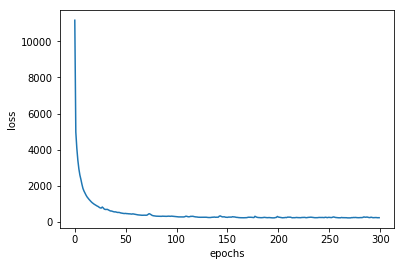

In [157]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [160]:
l2_pred = model.predict(l2)

In [161]:
pred = l2_pred[0].reshape(64, 64)

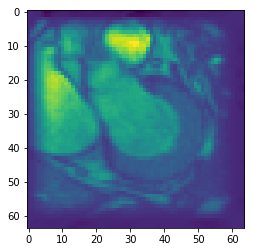

In [158]:
plt.imshow(l2[0].reshape(64,64))

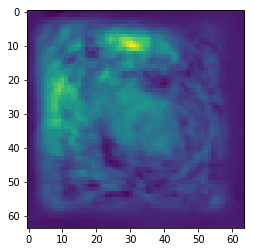

In [162]:
plt.imshow(pred)

#### 2nd part (Inferred shape)

In [237]:
input_y = l_contour.reshape((-1, 64*64))
input_x = l2_pred

In [238]:
model = Sequential()
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
#model.add(Dense(100, input_shape=[l2.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(0.0001), input_shape=[l2.shape[1]]))

In [239]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_41 (None, 4096) (None, 4096)


In [240]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [241]:
h2 = model.fit(input_x, input_y, epochs=10, verbose=2)

Epoch 1/10
9s - loss: 19707.4938 - acc: 0.0000e+00
Epoch 2/10
8s - loss: 4118.2714 - acc: 0.0000e+00
Epoch 3/10
8s - loss: 1601.7673 - acc: 0.0000e+00
Epoch 4/10
8s - loss: 837.8277 - acc: 0.0000e+00
Epoch 5/10
7s - loss: 554.8339 - acc: 0.0000e+00
Epoch 6/10
7s - loss: 393.6417 - acc: 0.0000e+00
Epoch 7/10
7s - loss: 304.5928 - acc: 0.0000e+00
Epoch 8/10
7s - loss: 231.9688 - acc: 0.0000e+00
Epoch 9/10
8s - loss: 197.8131 - acc: 0.0000e+00
Epoch 10/10
8s - loss: 151.4714 - acc: 0.0000e+00


Text(0.5,0,'epochs')

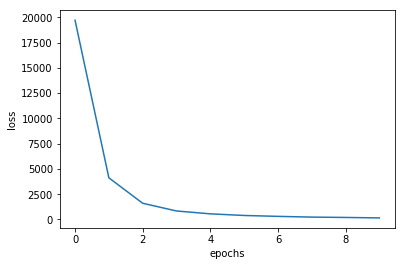

In [242]:
metric = 'loss'
plt.plot(range(len(h2.history[metric])), h2.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [243]:
l3_pred = model.predict(input_x)

In [244]:
pred3 = l3_pred[0].reshape(64, 64)

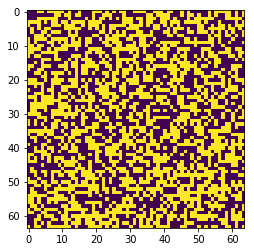

In [245]:
j = 17
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.THRESH_BINARY)
plt.imshow(p[1])

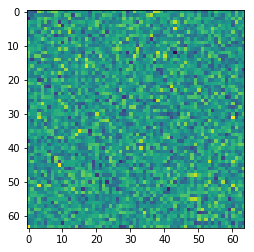

In [246]:
plt.imshow(pred3)